# Vicsek Model: Visualisations
#### Becky Crossley, Yulin Zhang, Shancheng Wang, Katy Fellingham

In this document, we produce various plots to visualise the results of the Vicsek Model. In order to do this, we need to import various libraries to help with plotting and maths. We also import 2 libraries we made ourselves, these are 'file_utility' and 'vicsek_model_lib'. The first of which contains the functions we require in order to save pictures and make videos. Alternatively, 'vicsek_model_lib' contains functions which define this model, and functions which help us analyse its results. 

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import file_utility as FU
import vicsek_model_lib as VM_lib

# Part 1

Here we create a visualisation of our birds using uniformly random positions and uniformly random initial orientations in a 15x15 container. See section 2.2 of attached "The Vicsek Model" for the derivation of our boundary conditions. 

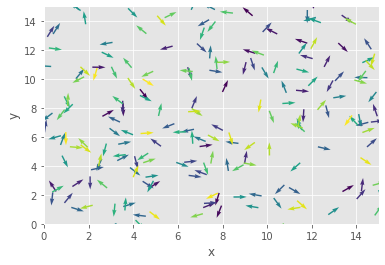

In [2]:
L = 15
N = 200
state = VM_lib.initialize(L,N)
plt.figure()
plt.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(len(state))) 
plt.xlim(0,15)
plt.ylim(0,15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Part 2

Here we determine the distances between all the birds, so we can use this to determine which are nearer than R. See section 2.2 for calculating the distance between birds. Function cal_pdist in vicsek_model_lib computes this.

In [3]:
A = VM_lib.cal_pdist(state[:,:2],L)
print(A)

[[0.         7.15265029 5.42753674 ... 7.8475451  8.18793135 6.58248567]
 [7.15265029 0.         3.70330533 ... 2.40856953 5.7881333  0.71257263]
 [5.42753674 3.70330533 0.         ... 5.85342039 6.02253672 3.6868861 ]
 ...
 [7.8475451  2.40856953 5.85342039 ... 0.         4.84275329 2.17471803]
 [8.18793135 5.7881333  6.02253672 ... 4.84275329 0.         6.15444422]
 [6.58248567 0.71257263 3.6868861  ... 2.17471803 6.15444422 0.        ]]


As expected, the elements of the matrix on the diagonal are all 0, as this is the distance between bird i and itself.

# Part 3

Now we are going to run our system for a long time, we choose T = 10,000 steps. For each time step, we also compute and record the Vicsek order parameter and plot this as a function of time. See section 2.1 for the mathematical description of the model, which is used to write the function update in vicsek_model_lib, and section 2.3 for the derivation of the burn-in function, which is required to calculate the Vicsek order parameter.

t=0


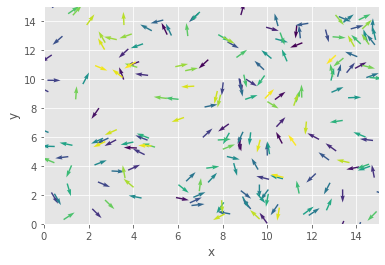

t=25


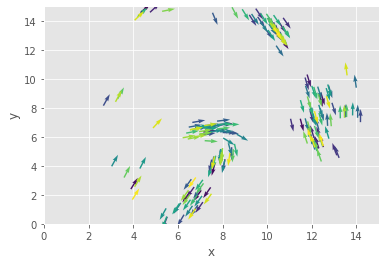

t=50


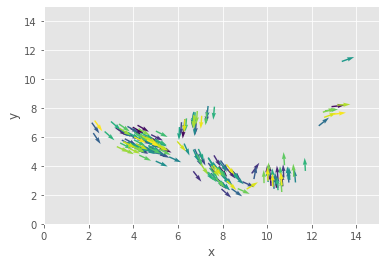

t=75


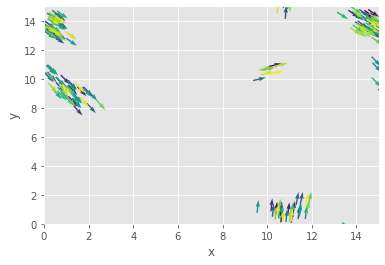

t=100


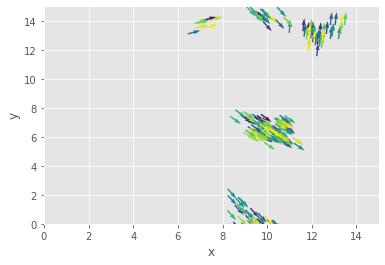

t=125


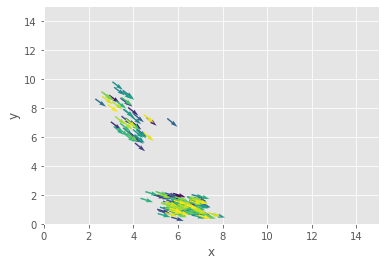

t=150


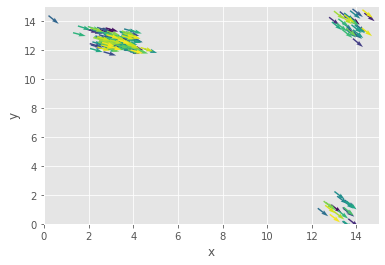

t=175


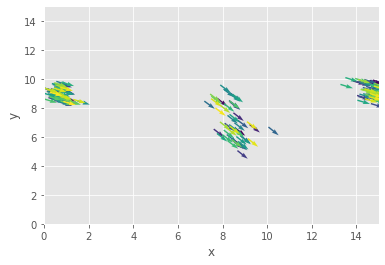

t=200


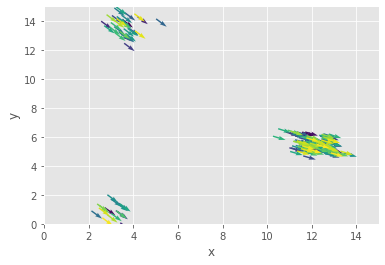

t=225


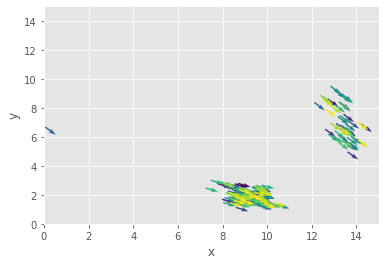

t=250


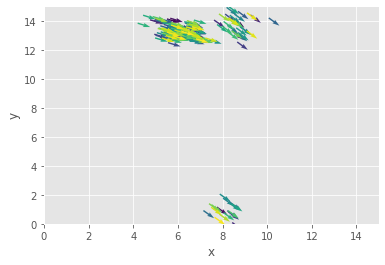

t=275


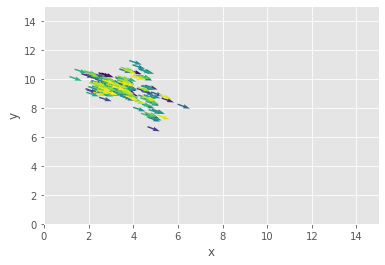

t=300


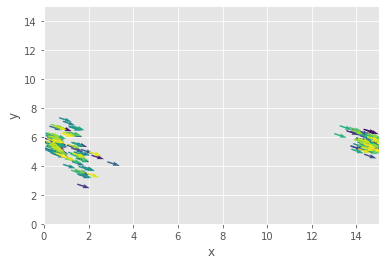

t=325


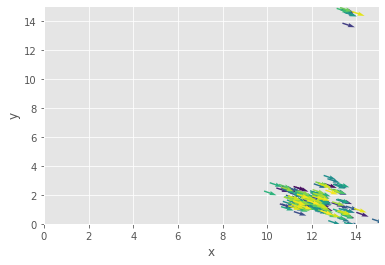

t=350


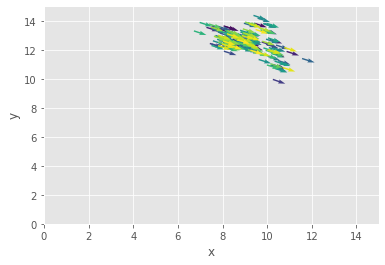

t=375


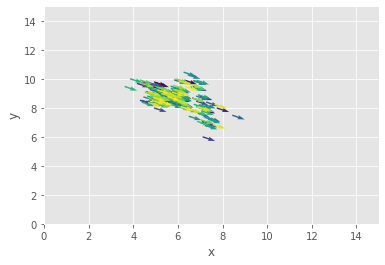

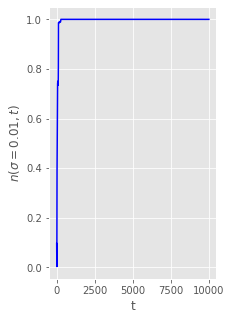

In [5]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.01  # std of noise
T = 10000  # total time steps
opara = np.zeros(T) # the Vicsek order parameter
fig_time = np.arange(0,400,25)

state = VM_lib.initialize(L,N)
for t in range(T):
    state,opara[t] = VM_lib.update_wop(state, L, v0, R, sigma)
    #representative plots
    if t in fig_time:
        print('t='+str(t))
        plt.figure()
        plt.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
        plt.xlim(0,15)
        plt.ylim(0,15)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

plt.figure(figsize=(3,5))
plt.plot(np.arange(T),opara,'b')   
plt.xlabel('t')
plt.ylabel(r'$n(\sigma=0.01,t)$')
plt.show()

We can see that the birds swarm together very quickly in time. When we look at the plot of $n(\sigma)$ against $t$, then we can see it plateau's by $t=1000$. 

We look at values of time less than 250 so that we can understand the behaviour more closely, and how it increases to reach steady state. 

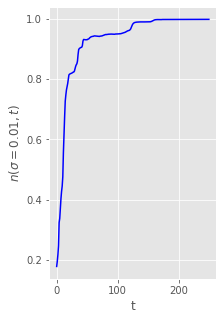

In [12]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.01  # std of noise
T = 250  # total time steps
opara = np.zeros(T) # the Vicsek order parameter

state = VM_lib.initialize(L,N)
for t in range(T):
    state,opara[t] = VM_lib.update_wop(state, L, v0, R, sigma)
plt.figure(figsize=(3,5))
plt.plot(np.arange(T),opara,'b')   
plt.xlabel('t')
plt.ylabel(r'$n(\sigma=0.01,t)$')
plt.show()

# Part 4

We now want to run our model for $t=1000$ and $\sigma=0.01$ and produce a movie to visualise flocking. 
Firstly, in order to do this, we write a function which encompasses our functions for defining each time step, and how to make a movie, so you only call one line and a video output is produced and saved.

In [ ]:
def visualize_simulation(N,L,v0,R,T,sigma,video_fps):
    """Make movies of the flocking simulation with different values of sigma.
    
    Parameters
    ----------
    N: int
        Number of individual birds
    L: float
        Size of the container(L*L)
    v0: float
        The constant velocity of the brids per time step
    R: float
        Radius within which for preys to search for neighbours
    T: int
        The total time steps of the simulation
    sigma: float
        Standard deviation of noise
    video_fps: int
        Frames per second of the video
    """
    # create folder to store the generated videos
    video_path = './Q4/Videos/'
    FU.createFolder(video_path)
    # create folder to store the generated pictures for different values of sigma
    pics_path = './Q4/VideoPics/sigma_{}/'.format(sigma)
    FU.createFolder(pics_path)

    state = VM_lib.initialize(L,N)
    for t in range(T):
        state, opara = VM_lib.update_wop(state, L, v0, R, sigma)
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
        ax.set_xlim(0,15)
        ax.set_ylim(0,15)
        fig.savefig(pics_path+'{}.png'.format(t))
        plt.close(fig)
    
    video_name = 'sigma_{}'.format(sigma)
    FU.makeVideo(pics_path,video_path,video_name,video_fps,T)

In [ ]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
T = 1000  # total time steps
video_fps = 12  # fps of the video

## Change the value of sigma for different simulations ##
sigma = 0.01  # std of noise
visualize_simulation(N,L,v0,R,T,sigma,video_fps)

# Part 5

We are now going to compute the $n(\sigma)$ phase transition plot. We do this by runnning $n$ traces and saving them in a csv ﬁle for each run of the system. Then we compute the average $n$ as a function of $\sigma$. Read section 2.3 regarding the burn-in function required to do this.

In [ ]:
def cal_n_sigma(N,L,v0,R,T,sigma_array):
    """Save traces of the vicsek model parameter for the flocking simulation with different values of sigma in a csv file.
    
    Parameters
    ----------
    N: int
        Number of individual birds
    L: float
        Size of the container(L*L)
    v0: float
        The constant velocity of the brids per time step
    R: float
        Radius within which for preys to search for neighbours
    T: int
        The total time steps of the simulation
    sigma_array: ndarray
        Different values of standard deviation of noise term
    """
    FU.createFolder('./Q5/')
    res = np.zeros((T,len(sigma_array)))
    for j in range(len(sigma_array)):
        sigma = sigma_array[j]
        state = VM_lib.initialize(L,N)
        for t in range(T):
            state,res[t,j] = VM_lib.update_wop(state,L,v0,R,sigma)
    
    df = pd.DataFrame(data=res,index=[i+1 for i in range(res.shape[0])],columns=[str(sigma) for sigma in sigma_array])
    df.to_csv('./Q5/n_sigma.csv')

In [ ]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
T = 10000  # total time steps

## change the value of sigma_array, sigma between 0 and 1 ##
sigma_array = np.linspace(0,1,50)

cal_n_sigma(N,L,v0,R,T,sigma_array)

In [ ]:
df = pd.read_csv('./Q5/n_sigma.csv') 
opara = df.to_numpy()[:,1:]
sigma_array = df.columns[1:].to_numpy(dtype=np.float)
t = VM_lib.burn_in(L,N,v0,R)  # we calculate the longest burn in time before the system to reach steady state
error_bar_mean = np.mean(opara[t:,:])
error_bar_std = np.std(opara[t:,:])

fig, ax = plt.subplots()
ax.errorbar(sigma_array, error_bar_mean,yerr=error_bar_std,fmt='-o')

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'error bar of $n(\sigma)$')
ax.set_title('Line plot with error bars')

plt.show()

In [ ]:
for j in len(sigma_array):
    plt.figure(figsize=(3,5))
    plt.plot(np.arange(len(opara)),res[t:,j],'b')    
    plt.xlabel('time steps')
    plt.ylabel('order parameter of sigma: '+str(sigma))
    plt.ylim(0,1.1)
    plt.show()

### Working out new method here

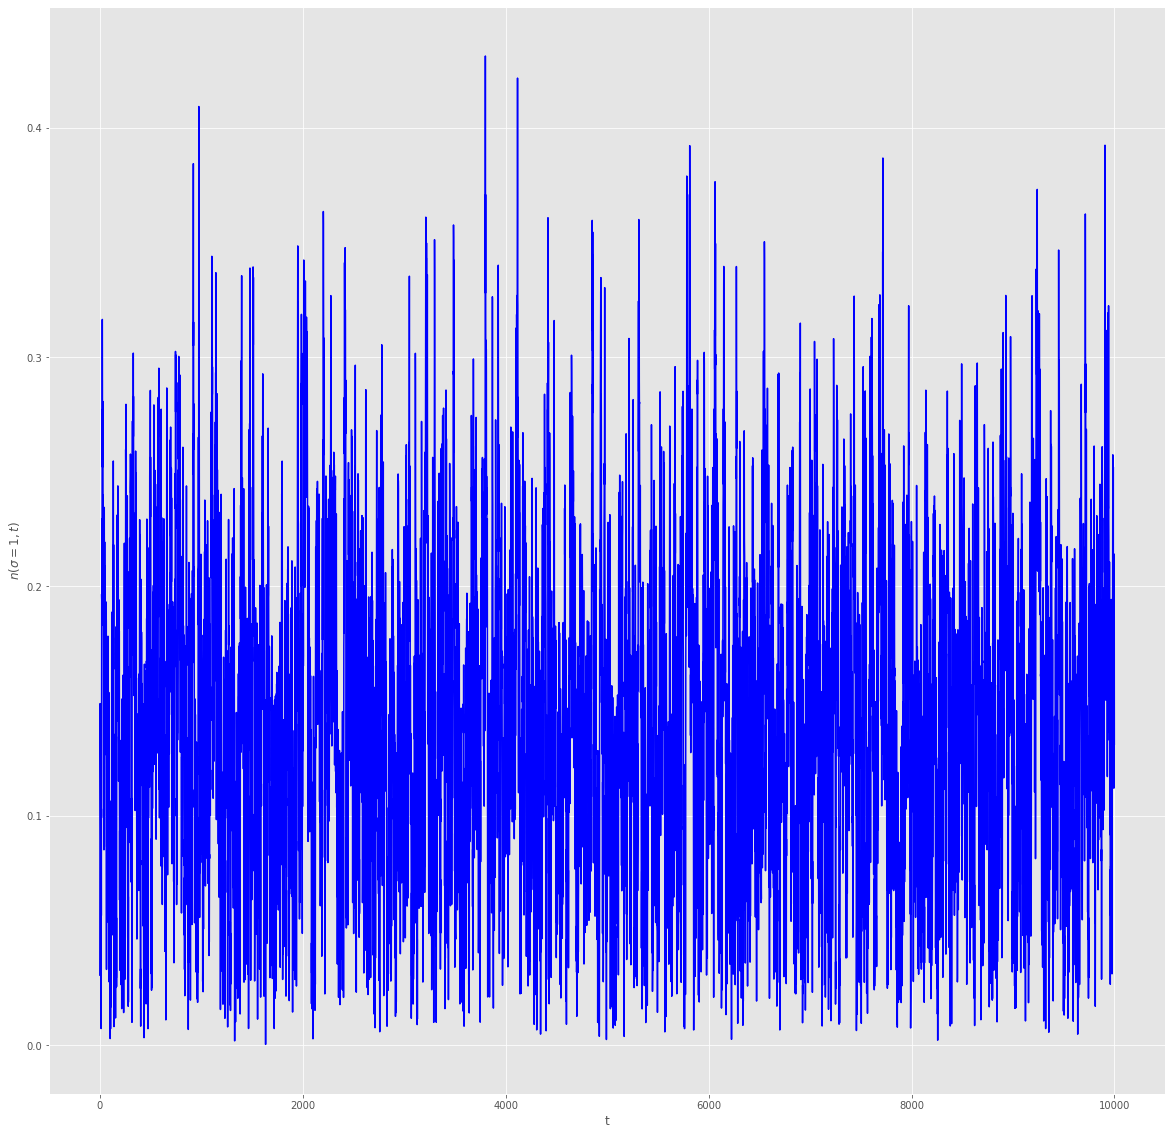

In [14]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 1  # std of noise
T = 10000  # total time steps
opara = np.zeros(T) # the Vicsek order parameter

state = VM_lib.initialize(L,N)
for t in range(T):
    state,opara[t] = VM_lib.update_wop(state, L, v0, R, sigma)
plt.figure(figsize=(20,20))
plt.plot(np.arange(T),opara,'b')   
plt.xlabel('t')
plt.ylabel(r'$n(\sigma=1,t)$')
plt.show()

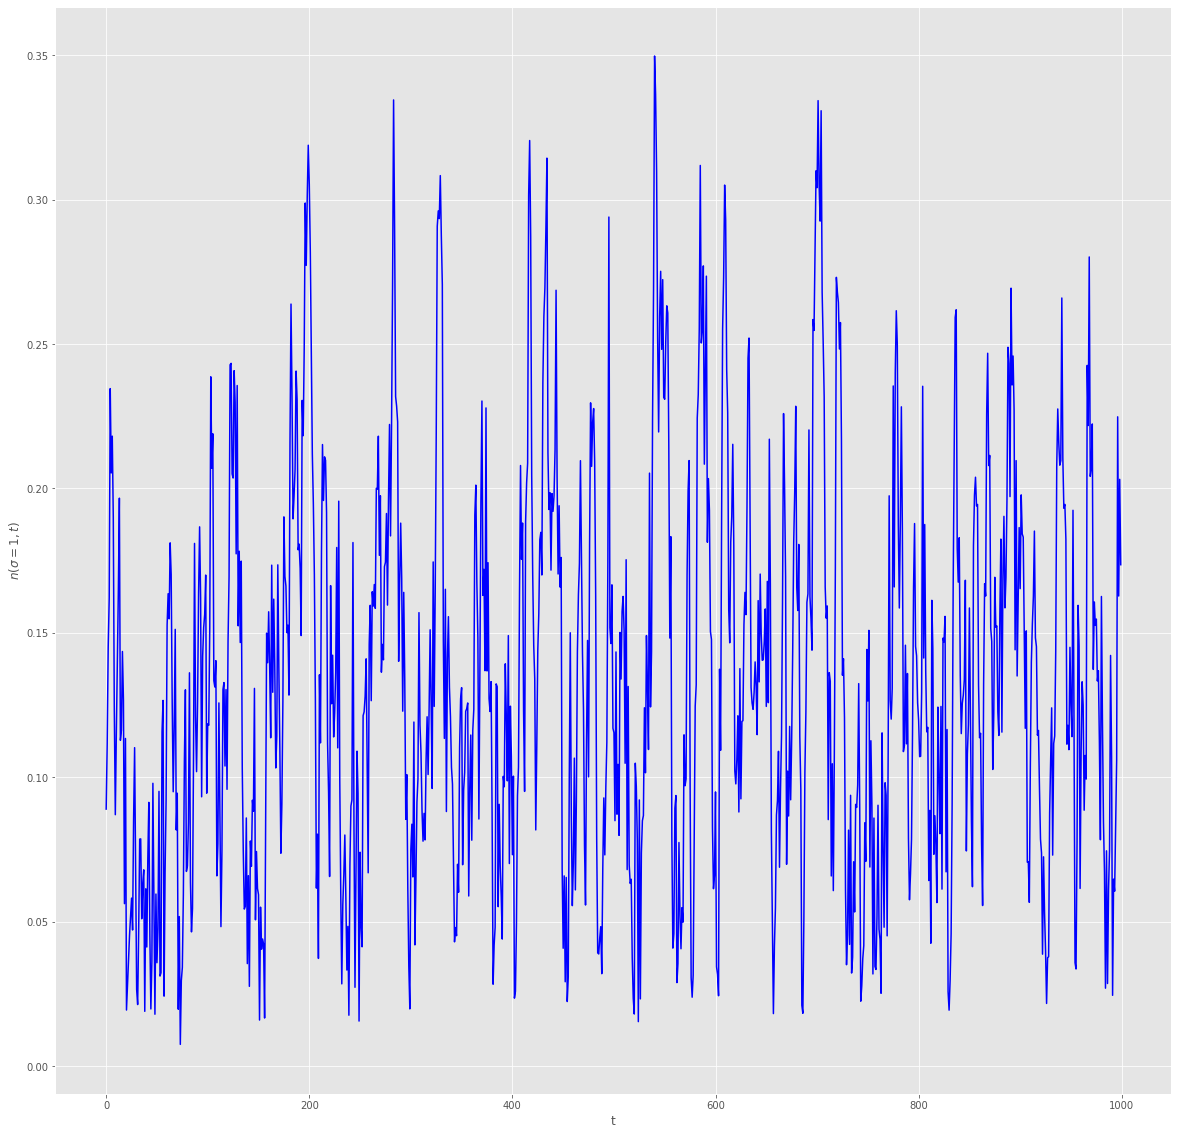

In [35]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 1  # std of noise
T = 1000  # total time steps
opara = np.zeros(T) # the Vicsek order parameter

state = VM_lib.initialize(L,N)
for t in range(T):
    state,opara[t] = VM_lib.update_wop(state, L, v0, R, sigma)
plt.figure(figsize=(20,20))
plt.plot(np.arange(T),opara,'b')   
plt.xlabel('t')
plt.ylabel(r'$n(\sigma=1,t)$')
plt.show()

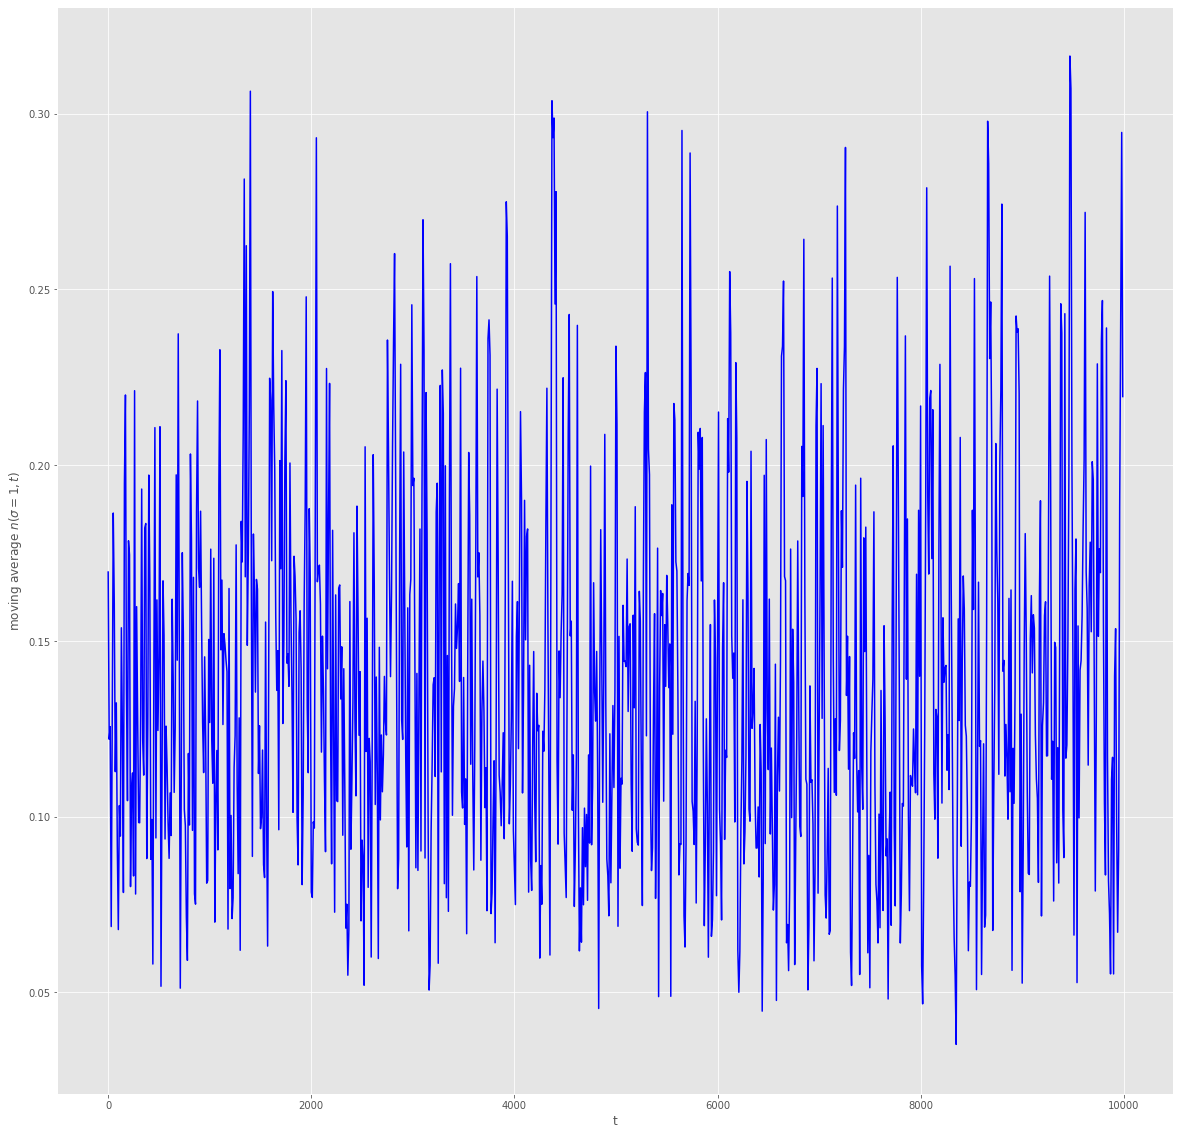

In [36]:
#make a new array with say 1/10 the number of points, 
#but where the order parameter value is the average of the 5 time steps before and after, 
#and then plot carefully.

N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 1  # std of noise
T = 10000  # total time steps
opara = np.zeros(T) # the Vicsek order parameter
av_time = np.arange(0,T,10)
av_opara = []


state = VM_lib.initialize(L,N)
for t in range(T):
    state,opara[t] = VM_lib.update_wop(state, L, v0, R, sigma)
for t in av_time:
    sumopara=0
    for i in range(t-5,t+5):
        sumopara=sumopara+opara[i]
    av_opara.append(sumopara/10)  

plt.figure(figsize=(20,20))
plt.plot(av_time,av_opara,'b')   
plt.xlabel('t')
plt.ylabel(r'moving average $n(\sigma=1,t)$')
plt.show() 

We think it reaches transient within 1000, so we look more closely at the moving average over the first 2000 steps here by the same method.

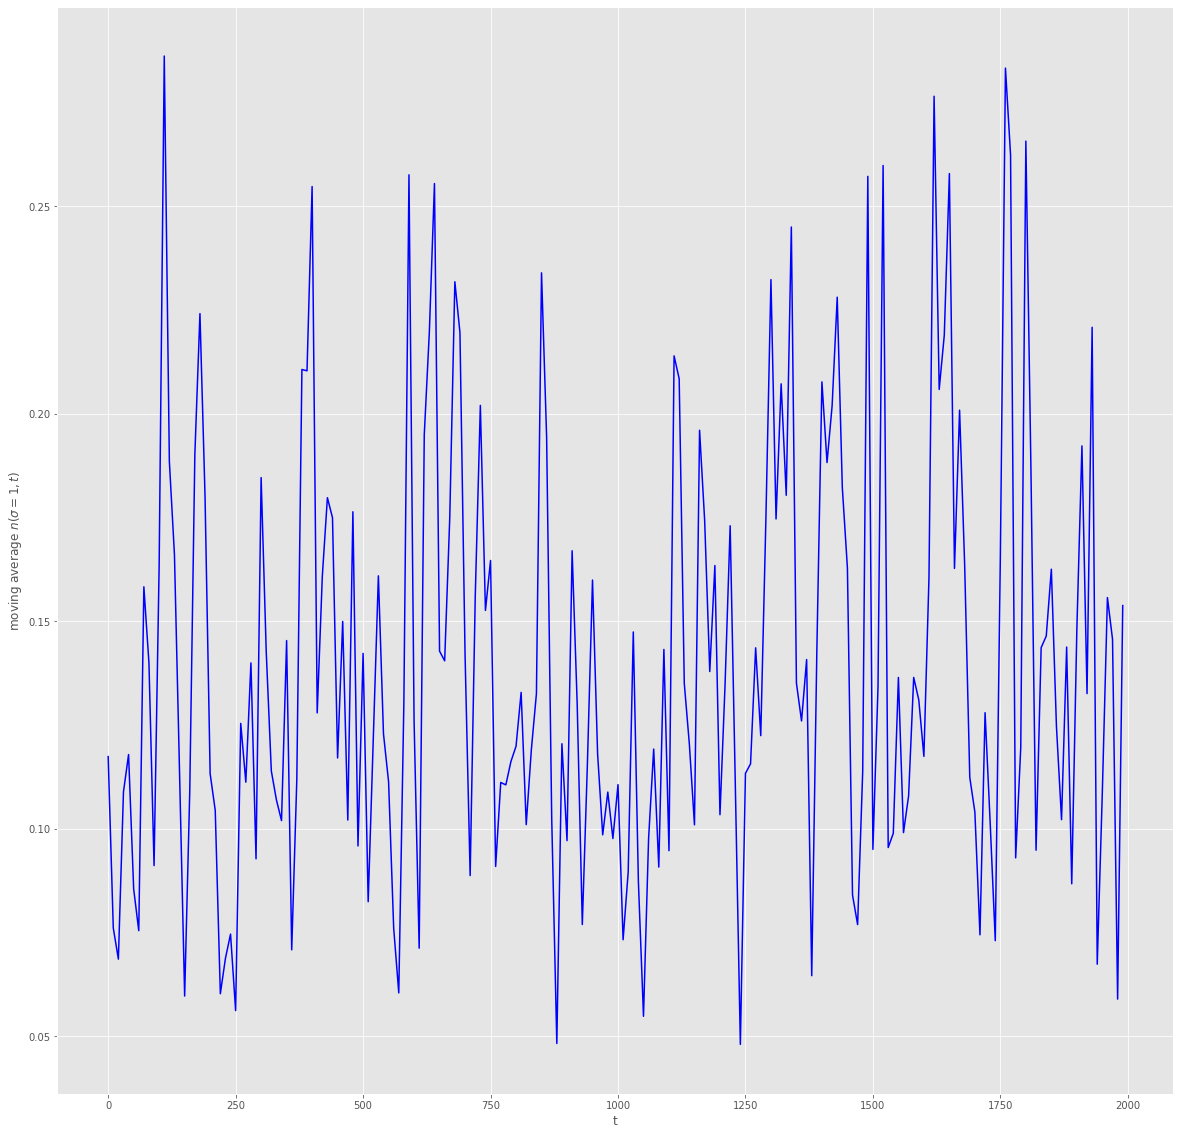

In [38]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 1  # std of noise
T = 2000  # total time steps
opara = np.zeros(T) # the Vicsek order parameter
av_time = np.arange(0,T,10)
av_opara = []


state = VM_lib.initialize(L,N)
for t in range(T):
    state,opara[t] = VM_lib.update_wop(state, L, v0, R, sigma)
for t in av_time:
    sumopara=0
    for i in range(t-5,t+5):
        sumopara=sumopara+opara[i]
    av_opara.append(sumopara/10)  

plt.figure(figsize=(20,20))
plt.plot(av_time,av_opara,'b')   
plt.xlabel('t')
plt.ylabel(r'moving average $n(\sigma=1,t)$')
plt.show() 

Although difficult to see exactly where, it does reach a steady state by $t=1000$

# Part 6

Again, we write a function we can call upon in order to produce a video representing potential bird swarming. This time, we are looking at the situation when there are predators present. See section 3 of "The Vicsek Model" for our derivation of the model with predators present.

In [ ]:
def visualize_simulation_pred(N,M,L,v0,v_predator,R,R_predator,R_run_away,T,sigma_prey,sigma_predator,video_fps):
    """Make movies of the flocking simulation with the existence of predators.
    
    Parameters
    ----------
    N: int
        Number of preys
    M: int
        Number of predators
    L: float
        Size of the container(L*L)
    v0: float
        The constant velocity of the preys per time step
    v_predator: float   
        The constant velocity of the preditor per time step
    R: float
        Radius within which for preys to search for neighbours
    R_predator: float
        Radius within which to catch the preys
    R_run_away: float
        Radius within which the prey spot the predator and try to run away
    T: int
        The total time steps of the simulation
    sigma_prey: float
        Standard deviation of noise of preys
    sigma_predator: float
        Standard deviation of noise of predators
    video_fps: int
        Frames per second of the video
    """
    opara = np.zeros(T) # the Vicsek order parameter
    # create folder to store the generated videos
    video_path = './Q6/Videos/'
    FU.createFolder(video_path)
    # create folder to store the generated pictures for different values of parameter
    pics_path = './Q6/VideoPics/v_predator_{}R_predator_{}/'.format(v_predator,R_predator)
    FU.createFolder(pics_path)
    prey, predator = VM_lib.initialize(L,N,M)
    for t in range(T):
        prey, predator, opara[t] = VM_lib.update_pred(prey, predator, L, v0, v_predator, R, R_predator, R_run_away, sigma_prey, sigma_predator)
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.quiver(prey[:,0],prey[:,1],np.cos(prey[:,2]),np.sin(prey[:,2]),color='k') 
        ax.quiver(predator[:,0],predator[:,1],np.cos(predator[:,2]),np.sin(predator[:,2]),color='r')
        ax.set_xlim(0,15)
        ax.set_ylim(0,15)
        fig.savefig(pics_path+'{}.png'.format(t))
        plt.close(fig)

    video_name = 'v_predator_{}R_predator_{}'.format(v_predator,R_predator)
    FU.makeVideo(pics_path,video_path,video_name,video_fps,T)

In [ ]:
N = 200  # number of preys
M = 3  # number of predators
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the preys per time step
v_predator = 0.7 # the constant velocity of the preditor per time step
R = 1 # radius within which to search for neighbours
R_predator = 3.5 # radius within which to catch the preys
R_run_away = 3.5 # radius within which the prey spot the predator and try to run away
sigma_prey = 0.01  # std of noise term of preys
sigma_predator = 0.01  # std of noise term of predators
T = 300  # total time steps
video_fps = 7  # fps of the video

visualize_simulation_pred(N,M,L,v0,v_predator,R,R_predator,R_run_away,T,sigma_prey,sigma_predator,video_fps)

